# Practice Session PS05: Recommendation engines (Content-based)

For this assignment we will build and use a content-based recommender system for movies. This content-based recommender will take as input a database of users and ratings on movies.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Àlex Montoya Pérez</font>

E-mail: <font color="blue">alex.montoya01@estudiant.upf.edu</font>

Date: <font color="blue">31/10/2023</font>

# **Google Colaboratory Setup & Imports**

In order to develop this laboratory, I used Google Colaboratory, since I have worked with different files I had to set up the environment as follows:


1.   Importing the drive module from the google.colab package.
2.   Mounting the Google Drive at the specified path (/content/drive).
3.   Changing the current working directory to the directory where I have all needed data /content/drive/MyDrive/MineriaDadesMasives/Labs/.

Verify that we are in the correct directory:


4.   Printing the current working directory path using !pwd.
5.   Listing the contents of the current directory using !ls.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Here is how to change current working directory
#By default the current working directory is /content
%cd /content/drive/MyDrive/MineriaDadesMasives/Labs/
#Print path and content of the current directory
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MineriaDadesMasives/Labs
/content/drive/MyDrive/MineriaDadesMasives/Labs
data				       ps04_association_rules.ipynb	ps08_data_streams.ipynb
old				       ps05_content_based_recsys.ipynb	ps09_forecasting.ipynb
ps01_02_data_preparation_242873.ipynb  ps06_item_based_recsys.ipynb	README.md
ps03_near_duplicates.ipynb	       ps07_outlier_analysis.ipynb


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [ ]:
# Leave this code as-is

FILENAME_MOVIES = "data/movielens-25M-filtered/movies-2000s.csv"
FILENAME_RATINGS = "data/movielens-25M-filtered/ratings-2000s.csv"
FILENAME_TAGS = "data/movielens-25M-filtered/tags-2000s.csv"


In [ ]:
# Leave this code as-is

movies = pd.read_csv(FILENAME_MOVIES,
                    sep=',',
                    engine='python',
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS,
                    sep=',',
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


## Adding year column to the dataframe


In [ ]:
def yearof(title):
    #Split title to get the age which is between parenthesis and then return it.
    split = title.split("(")
    resplit = split[len(split)-1].split(")")
    year = int(resplit[0])
    return year


movies['year'] = movies.apply(lambda x: yearof(x['title']), axis = 1)
display(movies.head(5))

,movie_id,title,genres,year
0,2769,"Yards, The (2000)",Crime|Drama,2000
1,3177,Next Friday (2000),Comedy,2000
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000
3,3225,Down to You (2000),Comedy|Romance,2000
4,3228,Wirey Spindell (2000),Comedy,2000


## Merge both dataframes

Both ratings_raw and users share the "user_id" column, making it possible to merge them based on this attribute. Similarly, both ratings_raw and movies possess the "movie_id" column, allowing you to combine them using this common field.

In [ ]:
#Merge both dataframes using pandas.merge
ratings = pd.merge(ratings_raw, movies, how = 'inner', on = 'movie_id')
display(ratings.head(5))

,user_id,movie_id,rating,title,genres,year
0,4,3624,2.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
1,152,3624,3.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
2,171,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
3,276,3624,4.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
4,494,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000


## Find Movies

In [ ]:
# function find_movies to easily find movies that contain a given keyword in its title.
def find_movies(text, movies):
    #For all the movies check
    for i in range(len(movies)):
        # Whether title has the input text
        if text in movies["title"][i]:
            #if it has it, print title and movie id
            print("movie_id: ", movies["movie_id"][i], ", title: ", movies["title"][i])
find_movies("Friday", movies)

movie_id:  3177 , title:  Next Friday (2000)
movie_id:  5874 , title:  Friday After Next (2002)
movie_id:  6593 , title:  Freaky Friday (2003)
movie_id:  7880 , title:  Friday Night (Vendredi Soir) (2002)
movie_id:  8937 , title:  Friday Night Lights (2004)
movie_id:  66783 , title:  Friday the 13th (2009)
movie_id:  97175 , title:  His Name Was Jason: 30 Years of Friday the 13th (2009)
movie_id:  121113 , title:  Shriek If You Know What I Did Last Friday the Thirteenth (2000)
movie_id:  133699 , title:  Black Friday (2004)
movie_id:  134649 , title:  Bad Hair Friday (2012)
movie_id:  161157 , title:  Friday (Pyatnitsa) (2016)
movie_id:  171951 , title:  Monster High: Friday Night Frights (2013)
movie_id:  192411 , title:  Freaky Friday (2018)
movie_id:  197903 , title:  Seven Days: Friday - Sunday (2015)


# 2. Exploratory Data Analysis

## 2.1. "Rating" variable

In [ ]:
# Leave this code as-is
ratings['rating'].describe()

count    472971.000000
mean          3.462222
std           1.076063
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## Histogram of ratings

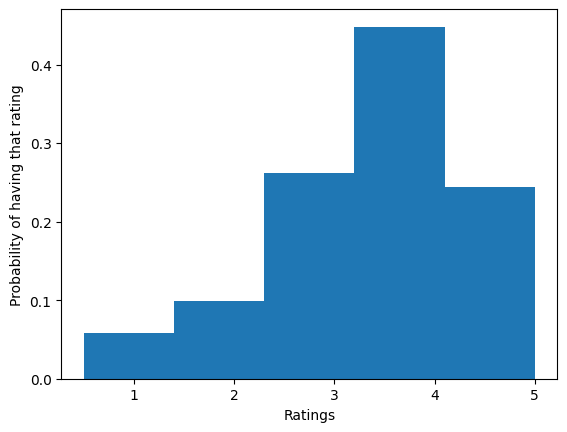

In [ ]:
x = ratings['rating']
#Plot the histogram with density = True to see probabilities and not the count,
# 5 bins since we have 5 ratings.
plt.hist(x, bins = 5, density = True, align = 'mid')
plt.xlabel("Ratings")
plt.ylabel("Probability of having that rating")
plt.show()

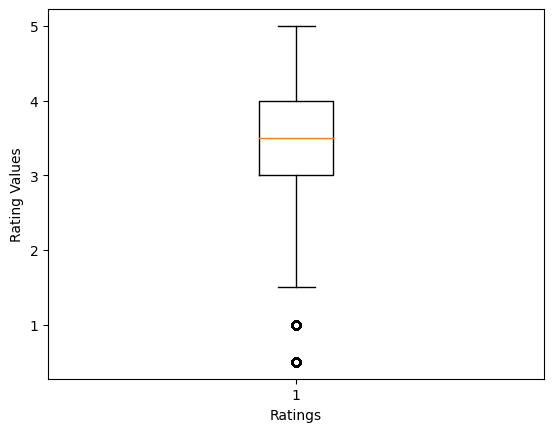

In [ ]:
x = ratings['rating']

# Create a boxplot
plt.boxplot(x)

plt.xlabel("Ratings")
plt.ylabel("Rating Values")

# Show the boxplot
plt.show()


As we can see from the Histogram and the Boxplot people tends to rate movies with a score of 3 or 4. Ratings below 3 are uncommon, likely because they are considered excessively low, while ratings of 5 are rarely given since they imply a perfect movie, which is a high standard to meet. In general, if a movie is deemed good, it is more likely to receive a rating of 4 or 5. Conversely, if it's considered bad, the rating is more likely to be 3 or lower.

## Good and Bad Ratings


In [ ]:
# good_ratings, containing only the subset of rows of ratings that has rating > 4.0
good_rating_value = 4
good_ratings = ratings[ratings.rating > good_rating_value] #Select movies with a rating > 4
good_ratings = good_ratings.sort_values('rating', ascending = False) # Sort them in descending order to see the highest-rated films
display(good_ratings.head(10), "Top 10 Highly Rated Movies")

print("\n")

# bad_ratings containing only the subset that has rating < 2.0.
bad_rating_value = 2
bad_ratings = ratings[ratings.rating < bad_rating_value]  #Select movies with a rating < 2
bad_ratings = bad_ratings.sort_values('rating', ascending = True) # Sort them in ascending order to see the lowest-rated films
display(bad_ratings.head(10), "Top 10 Lowest  Rated Movies")

,user_id,movie_id,rating,title,genres,year
13,3050,3624,5.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
129963,142226,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129945,141470,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129948,141675,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129949,141701,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129950,141705,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
334130,145457,8958,5.0,Ray (2004),Drama,2004
129952,141794,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129953,141831,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129954,141863,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004


'Top 10 Highly Rated Movies'

,user_id,movie_id,rating,title,genres,year
305982,103590,6535,0.5,"Legally Blonde 2: Red, White & Blonde (2003)",Comedy,2003
179078,136045,7254,0.5,The Butterfly Effect (2004),Drama|Sci-Fi|Thriller,2004
414998,74608,3991,0.5,102 Dalmatians (2000),Children|Comedy,2000
355902,6711,3273,0.5,Scream 3 (2000),Comedy|Horror|Mystery|Thriller,2000
261435,2287,4728,0.5,Rat Race (2001),Comedy,2001
179255,152546,7254,0.5,The Butterfly Effect (2004),Drama|Sci-Fi|Thriller,2004
179365,284,8368,0.5,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,2004
261424,160890,4701,0.5,Rush Hour 2 (2001),Action|Comedy,2001
179389,2005,8368,0.5,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,2004
414962,41234,3991,0.5,102 Dalmatians (2000),Children|Comedy,2000


'Top 10 Lowest  Rated Movies'

"Eternal Sunshine of the Spotless Mind" typically receives a rating of 5, which strongly indicates that this movie is considered good. In contrast, when 2 out of 10 people rate "Harry Potter and the Prisoner of Azkaban" with a low score of 0.5, it suggests that this movie may be perceived as bad. In general, the more people provide ratings that are consistently good or bad for a film, the higher the level of confidence you can have in assessing the film's quality.

## 2.2. Genres distribution

## List of all genres

In [ ]:
movie_genres =[]
genres_list = []

for i in range(len(movies)):
    # Split the genres of movies which have 2 or more genres.
    genres = movies['genres'][i].split('|')
    # if genre was not added before, we add it to the list.
    for genre in genres:
        if genre not in movie_genres:
            movie_genres.append(genre)

# Verify that the list has 20 genres
assert len(movie_genres) == 20

display(movie_genres)

['Crime',
 'Drama',
 'Comedy',
 'Adventure',
 'Sci-Fi',
 'Thriller',
 'Romance',
 'Horror',
 'Mystery',
 'Action',
 'Animation',
 'Children',
 'Documentary',
 'War',
 'Musical',
 'Western',
 'Fantasy',
 'IMAX',
 'Film-Noir',
 '(no genres listed)']

### Ordered for frequencies (most frequent to the least frequent)

In [ ]:
def frequency(dataset):
    movie_genres =[]
    list_to_check = []
    keyword_occurences = []
    # Add all genres as single to the movie_genres list
    for i in range(len(dataset)):
        genres = dataset['genres'][i].split('|')
        for genre in genres:
            movie_genres.append(genre)
    #Once we have them splitted, we count them and add them to the list we will return
    for genre in movie_genres:
        if genre not in list_to_check:
            list_to_check.append(genre)
            keyword_occurences.append([genre, movie_genres.count(genre)])
    # Return the list sorted by the count of each genre with sorted()
    return sorted(keyword_occurences, key = lambda x: x[1], reverse = True)

In [ ]:
# Print table of frequencies sorted from most frequent to the least frequent
display(frequency(movies))

[['Drama', 13666],
 ['Comedy', 8898],
 ['Thriller', 5437],
 ['Documentary', 4473],
 ['Action', 3901],
 ['Romance', 3846],
 ['Horror', 3431],
 ['Crime', 2425],
 ['(no genres listed)', 2200],
 ['Sci-Fi', 1907],
 ['Adventure', 1906],
 ['Children', 1639],
 ['Animation', 1553],
 ['Mystery', 1516],
 ['Fantasy', 1456],
 ['War', 679],
 ['Musical', 308],
 ['Western', 194],
 ['IMAX', 173],
 ['Film-Noir', 21]]

In [ ]:
#pip install wordcloud

## Word Cloud

In [ ]:
# Change the colors/style if you want
def wordcloud(keyword_occurences):
    # Generate the word cloud
    genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
    genre_wordcloud.generate_from_frequencies(dict(keyword_occurences))

    # Plot the word cloud
    f, ax = plt.subplots(figsize=(16, 8))
    plt.imshow(genre_wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

### Movies filmed before 2010

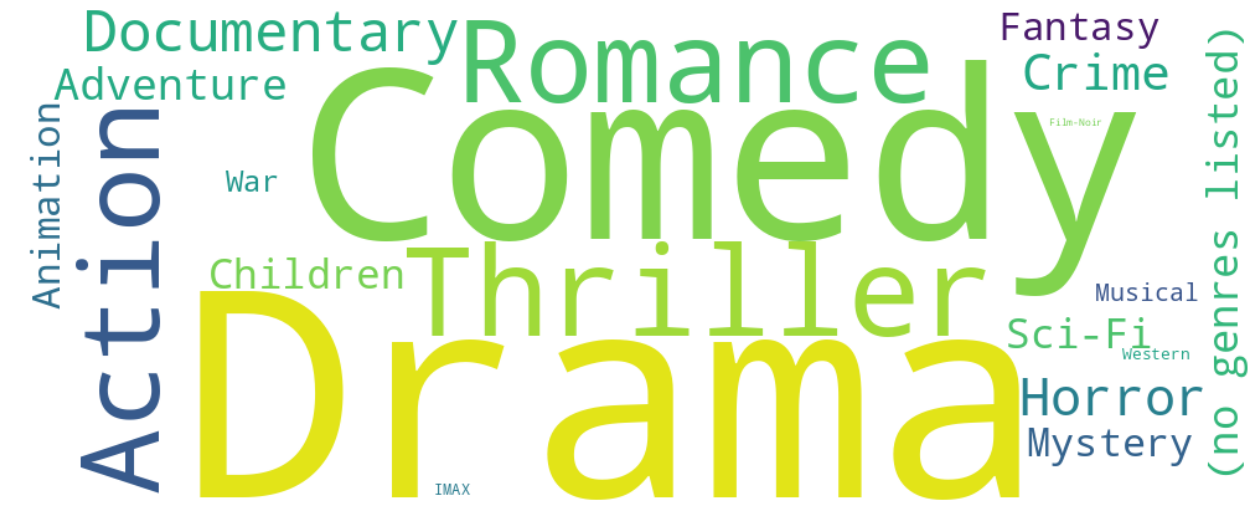

In [ ]:
#Split movies by movies before 2010.
pre_2010 = movies[movies.year < 2010]
#Reset_index to avoid missmatching
pre_2010 = pre_2010.reset_index()
#Compute frequency of genres
keyword_occurences_pre_2010 = frequency(pre_2010)
#Generate the wordcloud with the previous function
wordcloud(keyword_occurences_pre_2010)

### Movies filmed after 2010

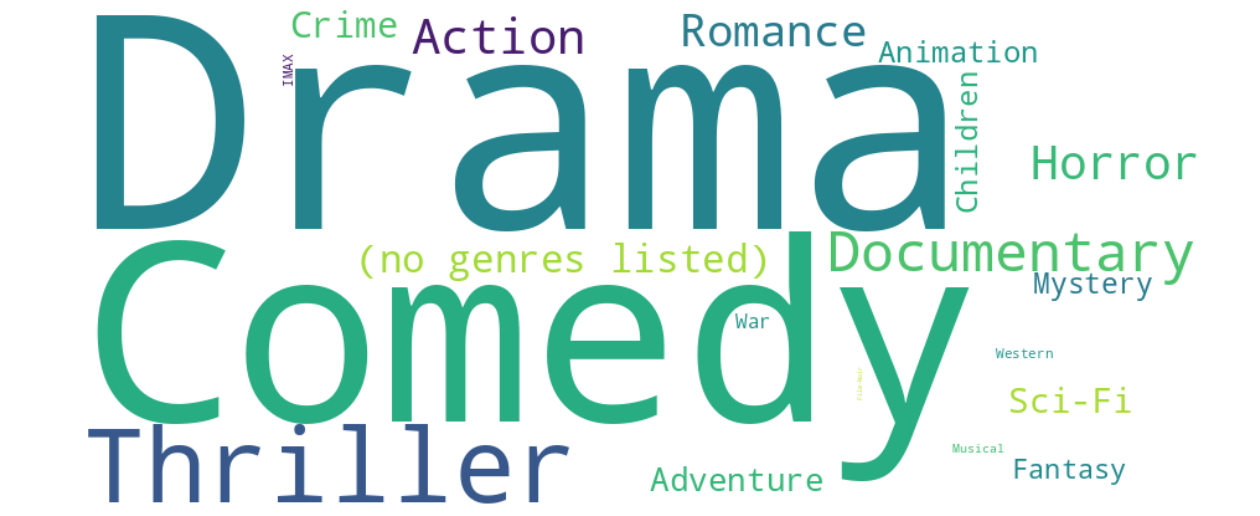

In [ ]:
#Split movies by movies before 2010.
post_2010 = movies[movies.year > 2010]
#Reset_index to avoid missmatching
post_2010 = post_2010.reset_index()
#Compute frequency of genres
keyword_occurences_post_2010 = frequency(post_2010)
#Generate the wordcloud with the previous function
wordcloud(keyword_occurences_post_2010)

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

## Adding column genres_arr to the dataframe

In [ ]:
genres_list = []
# Save all genres
for i in range(len(movies)):
    genres = movies['genres'][i].split('|')
    genres_list.append(genres)
#Add the column genres_arr with the genres_list as values.
movies['genres_arr'] = genres_list
# Convert it to string (will be useful later)
movies['genres_arr'].fillna('').astype('str')

display(movies.head(5))

,movie_id,title,genres,year,genres_arr
0,2769,"Yards, The (2000)",Crime|Drama,2000,"[Crime, Drama]"
1,3177,Next Friday (2000),Comedy,2000,[Comedy]
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000,"[Adventure, Sci-Fi, Thriller]"
3,3225,Down to You (2000),Comedy|Romance,2000,"[Comedy, Romance]"
4,3228,Wirey Spindell (2000),Comedy,2000,[Comedy]


In [ ]:
# Leave this code as-is
# Expected output:  "Transformed: Comedy|Romance → ['Comedy', 'Romance']""
print("Transformed: %s → %s" % (movies['genres'][3], movies['genres_arr'][3]))

Transformed: Comedy|Romance → ['Comedy', 'Romance']


In [ ]:
# LEAVE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year > 2015]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,year,genres_arr
0,10897,122888,Ben-hur (2016),(no genres listed),2016,[(no genres listed)]
1,10898,122890,Warcraft (2016),Action|Adventure|Fantasy,2016,"[Action, Adventure, Fantasy]"
2,10900,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017,[(no genres listed)]
3,10901,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017,"[Action, Adventure, Sci-Fi]"
4,10904,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,2016,"[Action, Adventure, Comedy, Sci-Fi]"


## Td-idf Matrix

In [ ]:
# prepare the vectorizer with ngram_range = 1,2 to consider one-and two-word genre and setup language to english
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
# Apply the Tfidf vectorizer to the dataset created previously
tfidf_matrix = vectorizer.fit_transform(movies_filtered['genres'])

# Matrix Shape --> The resulting matrix should have 7890 rows and 128 columns.
tfidf_matrix.shape

(7890, 128)

## 3.2. Calculate most similar movies

In [ ]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         1.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]
 ...
 [1.         0.         1.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.41022264]
 [0.         0.         0.         ... 0.         0.41022264 1.        ]]


In [ ]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):

    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]

    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))

print_similarity_vector(122904, cosine_sim)

Se han truncado las últimas 5000 líneas del flujo de salida.
0.161 180569 The Star (2017)
0.000 180571 The Mayor (2017)
0.000 180587 The Wife (2017)
0.000 180589 Leaning Into the Wind: Andy Goldsworthy (2017)
0.000 180591 Jane (2017)
0.061 180677 Child of Satan (2016)
0.057 180685 Before the Fall (2016)
0.000 180735 Hello Again (2017)
0.000 180737 A Christmas Prince (2017)
0.000 180763 LoveTrue (2016)
0.064 180793 Evil Bong: High 5 (2016)
0.000 180825 Pecking Order (2017)
0.419 180833 The Humanity Bureau (2017)
0.000 180835 The Lost Wife of Robert Durst (2017)
0.000 180837 Tokyo Project (2017)
0.000 180841 Interlude In Prague (2017)
0.161 180843 Schreckenstein Castle (2016)
0.000 180859 Bruce Springsteen: In His Own Words (2016)
0.000 180861 Ceasefire (2017)
0.000 180919 Starfish (2016)
0.178 180953 The Carer (2016)
0.000 180957 Eric Clapton: Life in 12 Bars (2017)
0.178 180959 The Bribe of Heaven (2016)
0.052 180965 The Healer (2017)
0.000 180973 Memoria (2016)
0.119 180975 Agadah (20

## Genre Content Based Recommendations function


In [ ]:
# Expected output:
## Element #1 with similarity 0.7
## Element #3 with similarity 0.4

# uses the similarity matrix and the list of movie titles to find the top-k most recommended movies for a given movie.
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]
    #
    # Create a list of the similarities for the movie asked.
    enumerated = list(enumerate(similarities[index_source]))
    # sort them descending
    sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
    # store the top "num_movies"
    top_similarities = sorted_similarities[0:num_movies]

    recommendations = []
    for (index_target, similarity) in top_similarities:

        # Replace this comment with code to obtain movie_id, title, genres
        #Obatin the movie_id, title and genre of the top "num_movies" similary movies.
        movie_id = movies['movie_id'][index_target]
        title = movies['title'][index_target]
        genres = movies['genres'][index_target]

        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )

    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

## Top 10 recommendations for "Pirates of the Caribbean"
(movie_id=122896)

In [ ]:
print("Top 10 recommendations for Pirates of the Caribbean: \n")
display(genre_content_based_recommendations(122896, movies, cosine_sim, num_movies = 10))

Top 10 recommendations for Pirates of the Caribbean: 



,similarity,movie_id,title,genres
0,1.0,2769,"Yards, The (2000)",Crime|Drama
1,1.0,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
2,1.0,3303,Black Tar Heroin: The Dark End of the Street (...,Documentary
3,1.0,3354,Mission to Mars (2000),Sci-Fi
4,1.0,3409,Final Destination (2000),Drama|Thriller
5,1.0,3511,Ready to Rumble (2000),Comedy
6,1.0,3555,U-571 (2000),Action|Thriller|War
7,1.0,3582,"Jails, Hospitals & Hip-Hop (2000)",Comedy|Documentary|Drama
8,1.0,3594,Center Stage (2000),Drama|Musical
9,1.0,3752,"Me, Myself & Irene (2000)",Adventure|Comedy


## Top 10 recommendations for "Midsommer"
 (movie_id=201646).

In [ ]:
print("Top 10 recommendations for Midsommer: \n")
display(genre_content_based_recommendations(201646, movies, cosine_sim, num_movies = 10))

Top 10 recommendations for Midsommer: 



,similarity,movie_id,title,genres
0,1.0,3909,Woman on Top (2000),Comedy|Romance
1,1.0,5094,Rollerball (2002),Action|Sci-Fi
2,1.0,5153,Trouble Every Day (2001),Drama|Horror|Thriller
3,1.0,6758,Emerald Cowboy (2002),Documentary|Drama
4,1.0,55555,"Edge of Heaven, The (Auf der anderen Seite) (2...",Drama
5,1.0,71139,ParaÃ­so Travel (2008),Adventure|Drama|Romance
6,1.0,73718,"Other Man, The (2008)",Drama
7,1.0,91947,"Revenant, The (2009)",Comedy|Horror
8,1.0,92120,Good Bye (BÃ© omid Ã© didar) (2011),Drama
9,1.0,92751,KokowÃ¤Ã¤h (2011),Comedy


## List of recommendations for three movies I am familiar with (after 2015)

### Movie 1: Green Book 2018

In [ ]:
# MOVIE 1 --> GREEN BOOK (2018)
print("Top 10 recommendations for Green Book: \n")
# Search the id of the movie we want the recommendations
id_movie_1 = movies.loc[movies['title'] == 'Green Book (2018)']['movie_id'].to_list()
# Apply the function created previously
display(genre_content_based_recommendations(id_movie_1[0], movies, cosine_sim, num_movies = 10))

Top 10 recommendations for Green Book: 



,similarity,movie_id,title,genres
0,1.0,3571,Time Code (2000),Comedy|Drama
1,1.0,3861,"Replacements, The (2000)",Comedy
2,1.0,3978,"Legend of Bagger Vance, The (2000)",Drama|Romance
3,1.0,4035,"Claim, The (2000)",Romance|Western
4,1.0,4068,Sugar & Spice (2001),Comedy
5,1.0,4144,In the Mood For Love (Fa yeung nin wa) (2000),Drama|Romance
6,1.0,4266,"Forsaken, The (2001)",Horror
7,1.0,4304,Startup.com (2001),Documentary
8,1.0,4646,Greenfingers (2000),Comedy|Drama
9,1.0,4727,Captain Corelli's Mandolin (2001),Drama|Romance|War


### Relevant/Unrelevant Manual Check
1. Time Code (2000) --> Relevant
2.  Replacements, The (2000) --> Unrelevant
3. Legend of Bagger Vance, The (2000) --> Unrelevant
4. Claim, The (2000) --> Unrelevant
5. Sugar & Spice (2001) --> Unrelevant
6. In the Mood For Love (Fa yeung nin wa) (2000) --> Unrelevant
7. Forsaken, The (2001) --> Unrelevant
8. Startup.com (2001)	--> Unrelevant
9. Greenfingers (2000) --> Unrelevant
10. Captain Corelli's Mandolin (2001)	--> Unrelevant

### Movie 2: Avengers: Infinity War - Part I (2018)

In [ ]:
# MOVIE 2 --> Avengers: Infinity War - Part I (2018)
print("Top 10 recommendations for Avengers: Infinity War \n")
# Search the id of the movie we want the recommendations
id_movie_2 = movies.loc[movies['title'] == 'Avengers: Infinity War - Part I (2018)']['movie_id'].to_list()
# Apply the function created previously
display(genre_content_based_recommendations(id_movie_2[0], movies, cosine_sim, num_movies = 10))

Top 10 recommendations for Avengers: Infinity War 



,similarity,movie_id,title,genres
0,1.0,3225,Down to You (2000),Comedy|Romance
1,1.0,3239,Isn't She Great? (2000),Comedy
2,1.0,3273,Scream 3 (2000),Comedy|Horror|Mystery|Thriller
3,1.0,3275,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller
4,1.0,3276,Gun Shy (2000),Comedy
5,1.0,3279,Knockout (2000),Action|Drama
6,1.0,3285,"Beach, The (2000)",Adventure|Drama
7,1.0,3286,Snow Day (2000),Comedy
8,1.0,3291,Trois (2000),Thriller
9,1.0,3322,3 Strikes (2000),Comedy


### Relevant/Unrelevant Manual Check
1. Down to You (2000)	 --> Unrelevant
2. Isn't She Great?(2000) --> Unrelevant
3. Scream 3 (2000) --> Unrelevant
4. Boondock Saints, The (2000) --> Unrelevant
5. Gun Shy (2000) --> Unrelevant
6. Knockout (2000) --> Relevant
7. Beach, The (2000) --> Relevant
8. Snow Day (2000)	--> Unrelevant
9. Trois (2000) --> Unrelevant
10. 3 Strikes (2000)	--> Unrelevant

### Movie 3: The Grinch (2018)

In [ ]:
# MOVIE 3 --> The Grinch (2018)
print("Top 10 recommendations for The Grinch \n")
# Search the id of the movie we want the recommendations
id_movie_3 = movies.loc[movies['title'] == 'The Grinch (2018)']['movie_id'].to_list()
# Apply the function created previously
display(genre_content_based_recommendations(id_movie_3[0], movies, cosine_sim, num_movies = 10))

Top 10 recommendations for The Grinch 



,similarity,movie_id,title,genres
0,1.0,5534,Hush! (2001),Drama
1,1.0,6548,Bad Boys II (2003),Action|Comedy|Crime|Thriller
2,1.0,6702,Dickie Roberts: Former Child Star (2003),Comedy
3,1.0,6965,Journeys with George (2002),Documentary
4,1.0,33136,House of D (2004),Drama
5,1.0,36477,"Baxter, The (2005)",Comedy|Drama|Romance
6,1.0,38798,In Her Shoes (2005),Comedy|Drama
7,1.0,49772,"Painted Veil, The (2006)",Drama|Romance
8,1.0,52037,Avenue Montaigne (Fauteuils d'orchestre) (2006),Comedy|Drama|Romance
9,1.0,55245,Good Luck Chuck (2007),Comedy|Romance


### Relevant/Unrelevant Manual Check
1. Hush! (2001)	 --> Unrelevant
2. Bad Boys II (2003) --> Unrelevant
3. Dickie Roberts: Former Child Star (2003)	 --> Unrelevant
4. Journeys with George (2002) --> Unrelevant
5. House of D (2004)--> Unrelevant
6. Baxter, The (2005) --> Relevant
7. In Her Shoes (2005) --> Unrelevant
8. Painted Veil, The (2006)	--> Unrelevant
9. Avenue Montaigne (Fauteuils d'orchestre) (2006) --> Unrelevant
10. Good Luck Chuck (2007)	--> Unrelevant

## Average precision in each case (based in my criteria)
Formular applied:  *Number of relevant movies / 10*

*   Movie 1: Green Book 2018 -->  1/10
*   Movie 2: Avengers: Infinity War - Part I (2018) -->  2/10
*   Movie 3: Spider-Man: Far from Home (2019)  -->  1/10

Total Average -->   Number of relevant movies 4/30

### Recommenadations
I suggest endorsing only high-quality films. While some movies may share similarities, I would refrain from recommending any that are deemed subpar. Furthermore, it would be beneficial to incorporate more precise genre classifications.

Additionally, as I introduce various facets, employing techniques such as Principal Components Analysis becomes imperative to mitigate the challenges posed by the curse of dimensionality. The distinction between having 20 years instead of 10 is not equivalent to having 30 years instead of 20. Thus, the attributes to consider for recommendations should vary depending on

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>